# Homework 9
## Mengxiang Jiang

The majority of the code here comes from the [Companion Jupyter notebooks for the book "Deep Learning with Python"](https://github.com/fchollet/deep-learning-with-python-notebooks) by François Chollet, specifically chapter 9.
If the code comes from somewhere else it will have a source linked to the original.\
[Video Link](https://youtu.be/IgyaMNmL7Ts)

## Experiment 1: Image Segmentation Book Example

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
--2023-04-04 16:20:39--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-04-04 16:20:39--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-04-04 16:20:40--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.

In [2]:
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /home/mengxiang/miniconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [1]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

2023-04-04 19:06:32.889596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-04 19:06:33.023953: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


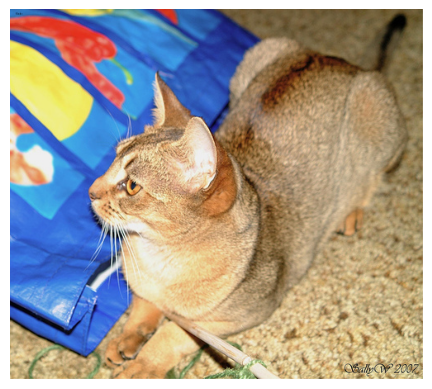

In [2]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import load_img, img_to_array

plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

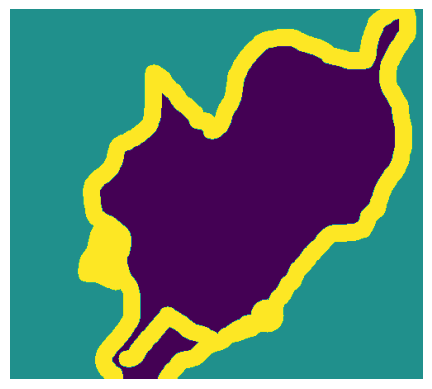

In [3]:
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale"))
display_target(img)

In [4]:
import numpy as np
import random

img_size = (200, 200)
num_imgs = len(input_img_paths)

random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_paths)

def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [5]:
from tensorflow import keras
from tensorflow.keras import layers

In [7]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 25, 25, 256)       295168

2023-04-04 16:23:59.902496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 16:23:59.911287: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 16:23:59.911372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 16:23:59.911930: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [8]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="oxford_segmentation.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50


2023-04-04 16:27:44.074265: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-04 16:27:46.319372: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-04 16:27:46.320471: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-04 16:27:46.506326: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7efd48cc3ef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-04 16:27:46.506496: I tensorflow/compiler/xla/service/service.cc:181]   Str

200/200 [==============================] - 25s 97ms/step - loss: 0.9277 - accuracy: 0.5784 - val_loss: 0.8761 - val_accuracy: 0.5839
Epoch 2/50
200/200 [==============================] - 18s 89ms/step - loss: 0.8295 - accuracy: 0.6259 - val_loss: 0.7999 - val_accuracy: 0.6384
Epoch 3/50
200/200 [==============================] - 18s 90ms/step - loss: 0.7745 - accuracy: 0.6839 - val_loss: 0.7670 - val_accuracy: 0.6919
Epoch 4/50
200/200 [==============================] - 18s 91ms/step - loss: 0.7537 - accuracy: 0.6932 - val_loss: 0.7243 - val_accuracy: 0.7037
Epoch 5/50
200/200 [==============================] - 18s 92ms/step - loss: 0.7194 - accuracy: 0.7053 - val_loss: 0.7435 - val_accuracy: 0.6928
Epoch 6/50
200/200 [==============================] - 18s 91ms/step - loss: 0.6726 - accuracy: 0.7274 - val_loss: 0.5971 - val_accuracy: 0.7607
Epoch 7/50
200/200 [==============================] - 18s 91ms/step - loss: 0.6388 - accuracy: 0.7422 - val_loss: 0.5799 - val_accuracy: 0.7655
Epo

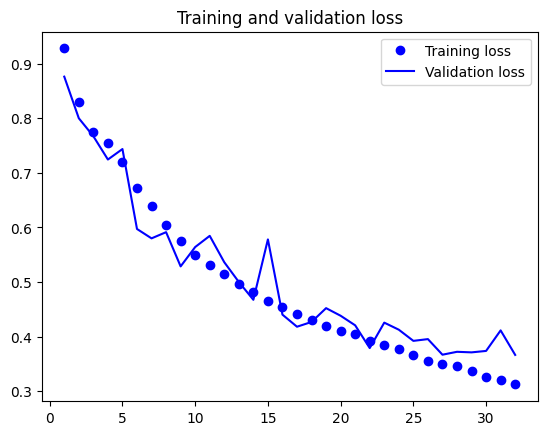

In [9]:
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

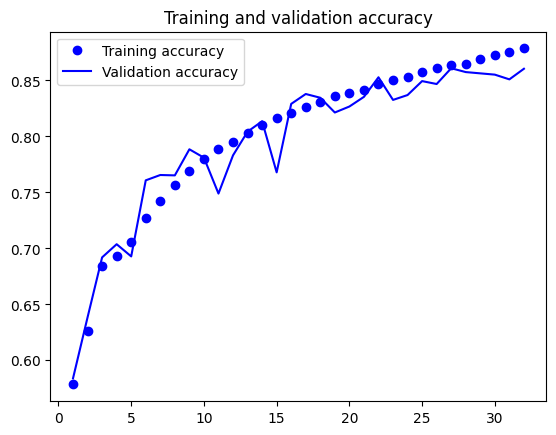

In [10]:
epochs = range(1, len(history.history["accuracy"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

2023-04-04 19:07:01.798102: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 19:07:01.806239: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 19:07:01.806319: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 19:07:01.806876: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

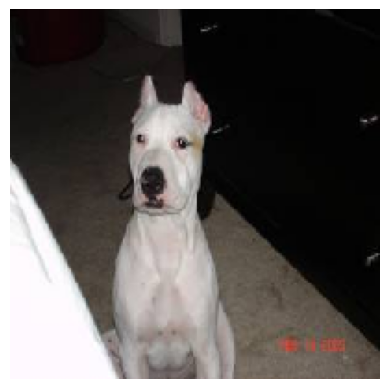

In [6]:
from tensorflow.keras.utils import array_to_img

model = keras.models.load_model("oxford_segmentation.keras")

i = 4
test_image = val_input_imgs[i]
plt.axis("off")
plt.imshow(array_to_img(test_image))

2023-04-04 19:07:10.288204: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100


1/1 [==============================] - 2s 2s/step


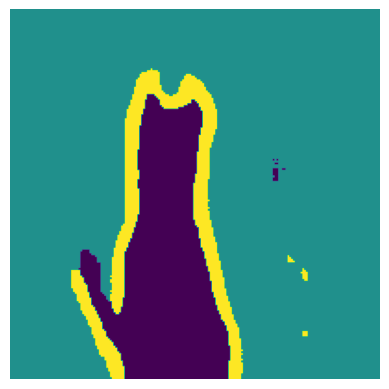

In [7]:
mask = model.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In [13]:
best_val_loss = min(history.history['val_loss'])
print('Best validation loss:', best_val_loss)
best_val_accuracy = max(history.history['val_accuracy'])
print('Best validation accuracy:', best_val_accuracy)

Best validation loss: 0.36639317870140076
Best validation accuracy: 0.860864520072937


**Conclusion**

The Conv2DTranspose layers almost feel magical in their ability to reconstruct the original image after the downsampling from the normal Conv2D layers. The resulting segmentation sample test image looks very good, although it seems to have seen an imaginary tail on the dog when the original picture does not show it.

## Experiment 2: Image Segmentation with SeparableConv2D layers


In [6]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.SeparableConv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.SeparableConv2D(256, 3, activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.SeparableConv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model2 = get_model(img_size=img_size, num_classes=3)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1792      
                                                                 
 separable_conv2d (Separable  (None, 100, 100, 64)     4736      
 Conv2D)                                                         
                                                                 
 separable_conv2d_1 (Separab  (None, 50, 50, 128)      8896      
 leConv2D)                                                       
                                                                 
 separable_conv2d_2 (Separab  (None, 50, 50, 128)      17664 

2023-04-04 17:15:11.575115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 17:15:11.585182: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 17:15:11.585323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-04 17:15:11.585772: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuil

In [7]:
model2.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="oxford_segmentation2.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]

In [7]:
history2 = model2.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50


2023-04-04 16:54:40.898916: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-04 16:54:42.703708: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f2acf81e030 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-04 16:54:42.703881: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-04-04 16:54:42.733529: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-04 16:54:42.871420: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 23s 91ms/step - loss: 0.9351 - accuracy: 0.5792 - val_loss: 0.8941 - val_accuracy: 0.5839
Epoch 2/50
200/200 [==============================] - 17s 86ms/step - loss: 0.8680 - accuracy: 0.5815 - val_loss: 0.8555 - val_accuracy: 0.5839
Epoch 3/50
200/200 [==============================] - 18s 88ms/step - loss: 0.8597 - accuracy: 0.5813 - val_loss: 0.8443 - val_accuracy: 0.5839
Epoch 4/50
200/200 [==============================] - 18s 90ms/step - loss: 0.8439 - accuracy: 0.5810 - val_loss: 0.8309 - val_accuracy: 0.5837
Epoch 5/50
200/200 [==============================] - 17s 87ms/step - loss: 0.8278 - accuracy: 0.5971 - val_loss: 0.8123 - val_accuracy: 0.6314
Epoch 6/50
200/200 [==============================] - 17s 86ms/step - loss: 0.8263 - accuracy: 0.6133 - val_loss: 0.8153 - val_accuracy: 0.6417
Epoch 7/50
200/200 [==============================] - 17s 86ms/step - loss: 0.8121 - accuracy: 0.6345 - val_loss: 0.8024 - val_accuracy: 0.6466
Epo

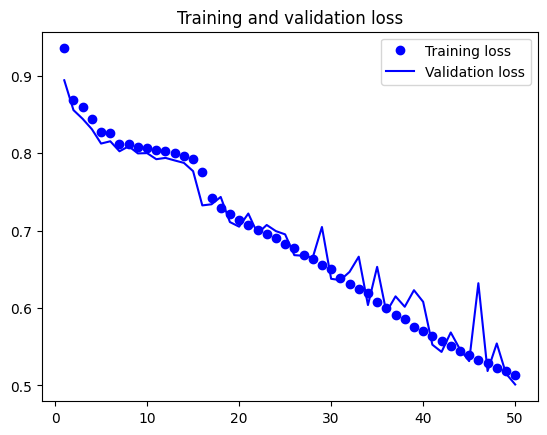

In [8]:
epochs = range(1, len(history2.history["loss"]) + 1)
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

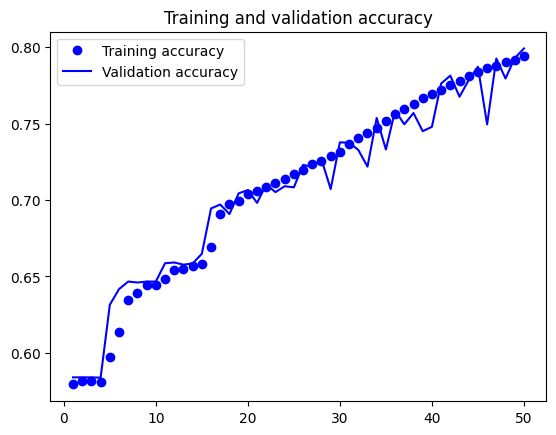

In [9]:
epochs = range(1, len(history2.history["accuracy"]) + 1)
loss = history2.history["accuracy"]
val_loss = history2.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

**Since it looks like the model is still underfitting, decided to train for 50 more epochs**

In [8]:
model2 = keras.models.load_model("oxford_segmentation2.keras")

history2 = model2.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50


2023-04-04 17:16:00.347221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-04-04 17:16:02.230739: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f48b20611f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-04-04 17:16:02.230764: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2023-04-04 17:16:02.242259: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-04-04 17:16:02.363259: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 [==============================] - 24s 97ms/step - loss: 0.5078 - accuracy: 0.7973 - val_loss: 0.5022 - val_accuracy: 0.7996
Epoch 2/50
200/200 [==============================] - 18s 91ms/step - loss: 0.5014 - accuracy: 0.7995 - val_loss: 0.4971 - val_accuracy: 0.8024
Epoch 3/50
200/200 [==============================] - 18s 91ms/step - loss: 0.4972 - accuracy: 0.8012 - val_loss: 0.4990 - val_accuracy: 0.8008
Epoch 4/50
200/200 [==============================] - 18s 90ms/step - loss: 0.4885 - accuracy: 0.8053 - val_loss: 0.5075 - val_accuracy: 0.7953
Epoch 5/50
200/200 [==============================] - 18s 90ms/step - loss: 0.4880 - accuracy: 0.8054 - val_loss: 0.5870 - val_accuracy: 0.7673
Epoch 6/50
200/200 [==============================] - 18s 91ms/step - loss: 0.4811 - accuracy: 0.8083 - val_loss: 0.4816 - val_accuracy: 0.8074
Epoch 7/50
200/200 [==============================] - 18s 90ms/step - loss: 0.4735 - accuracy: 0.8115 - val_loss: 0.5074 - val_accuracy: 0.7962
Epo

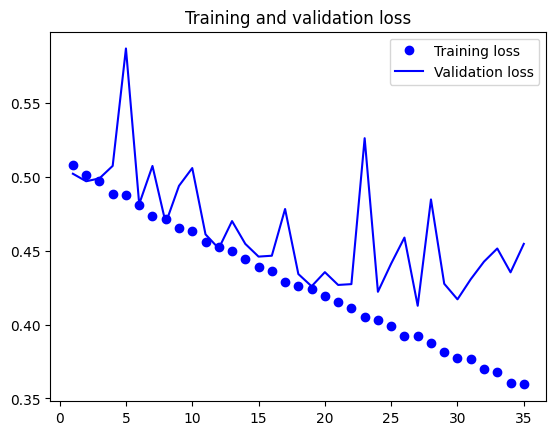

In [13]:
epochs = range(1, len(history2.history["loss"]) + 1)
loss = history2.history["loss"]
val_loss = history2.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

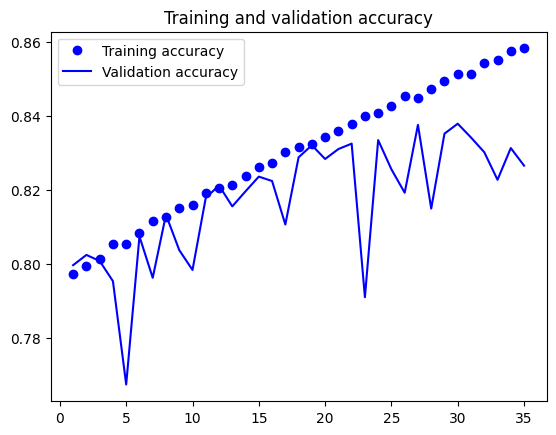

In [14]:
epochs = range(1, len(history2.history["accuracy"]) + 1)
loss = history2.history["accuracy"]
val_loss = history2.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

1/1 [==============================] - 0s 134ms/step


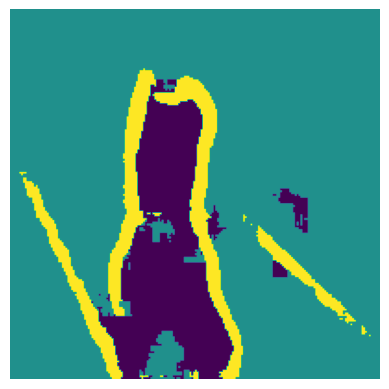

In [12]:
mask = model2.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In [15]:
best_val_loss = min(history2.history['val_loss'])
print('Best validation loss:', best_val_loss)
best_val_accuracy = max(history2.history['val_accuracy'])
print('Best validation accuracy:', best_val_accuracy)

Best validation loss: 0.4127655625343323
Best validation accuracy: 0.8379148840904236


**Conclusion**

Even though the book claims using SeparableConv2D layers as drop-in replacement for Conv2D layers will cause it to perform a few percentage points better, the results I got suggest otherwise. The number of learnable parameters is much lower which does make the model smaller as the book claims, but this more than doubled the number of epochs required to train it before overfitting, which contradicts the book's claim that the model converges faster. And the end result is a lower validation accuracy, with the sampled test image clearly looking less clean as well as with more error regions.

## Experiment 3: Image Segmentation with a Residual Connection

In [16]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    residual = x
    x = layers.Conv2D(64, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", activation="relu")(x)
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)

    residual = layers.Conv2D(256, 1, strides=8)(residual)
    x = layers.add([x, residual])
    
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(256, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(128, 3, activation="relu", padding="same", strides=2)(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
    x = layers.Conv2DTranspose(64, 3, activation="relu", padding="same", strides=2)(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model3 = get_model(img_size=img_size, num_classes=3)
model3.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 200, 200, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 100, 100, 64  1792        ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                            

In [17]:
model3.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="oxford_segmentation3.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]

In [18]:
history3 = model3.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50


2023-04-04 17:39:27.143574: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-04 17:39:27.144031: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


200/200 [==============================] - 24s 101ms/step - loss: 0.9173 - accuracy: 0.5789 - val_loss: 0.8459 - val_accuracy: 0.5839
Epoch 2/50
200/200 [==============================] - 19s 95ms/step - loss: 0.8502 - accuracy: 0.5926 - val_loss: 0.7963 - val_accuracy: 0.6415
Epoch 3/50
200/200 [==============================] - 19s 95ms/step - loss: 0.7942 - accuracy: 0.6643 - val_loss: 0.7556 - val_accuracy: 0.6945
Epoch 4/50
200/200 [==============================] - 19s 96ms/step - loss: 0.7479 - accuracy: 0.6933 - val_loss: 0.7142 - val_accuracy: 0.7011
Epoch 5/50
200/200 [==============================] - 19s 96ms/step - loss: 0.7018 - accuracy: 0.7090 - val_loss: 0.6553 - val_accuracy: 0.7331
Epoch 6/50
200/200 [==============================] - 19s 96ms/step - loss: 0.6628 - accuracy: 0.7296 - val_loss: 0.6437 - val_accuracy: 0.7342
Epoch 7/50
200/200 [==============================] - 19s 97ms/step - loss: 0.6161 - accuracy: 0.7492 - val_loss: 0.6240 - val_accuracy: 0.7511
Ep

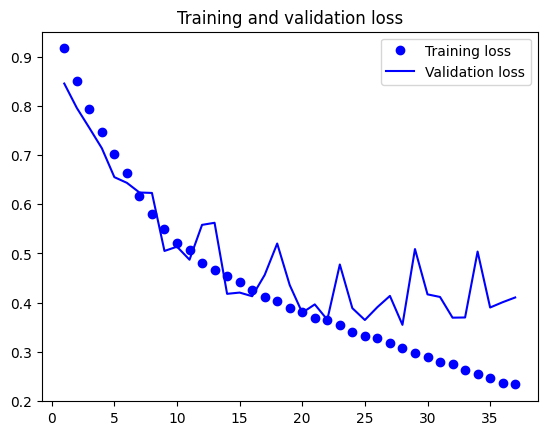

In [19]:
epochs = range(1, len(history3.history["loss"]) + 1)
loss = history3.history["loss"]
val_loss = history3.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

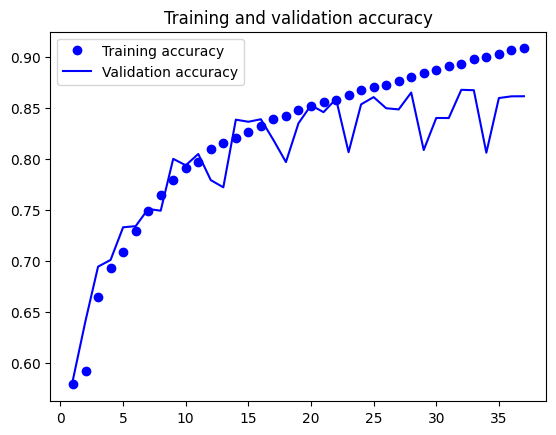

In [20]:
epochs = range(1, len(history3.history["accuracy"]) + 1)
loss = history3.history["accuracy"]
val_loss = history3.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

1/1 [==============================] - 0s 90ms/step


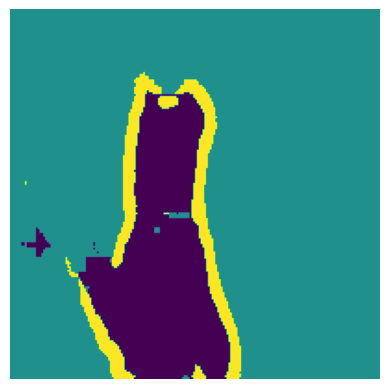

In [21]:
mask = model3.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In [22]:
best_val_loss = min(history3.history['val_loss'])
print('Best validation loss:', best_val_loss)
best_val_accuracy = max(history3.history['val_accuracy'])
print('Best validation accuracy:', best_val_accuracy)

Best validation loss: 0.3545621633529663
Best validation accuracy: 0.8679630160331726


**Conclusion**

The addition of the residual connection of the original image before the Conv2DTranspose did improve the validation accuracy a little. The book claims this is because the residual connection acts as an information shortcut in order to reduce the vanishing gradients problem. The segmentation of the sampled test image doesn't look as clean as the original model, though it is just one sample.

## Experiment 4: Image Segmentation with Batch Normalization


In [8]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(64, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2DTranspose(256, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(256, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(128, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(128, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(64, 3, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2DTranspose(64, 3, strides=2, padding="same", use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model

model4 = get_model(img_size=img_size, num_classes=3)
model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 64)      1728      
                                                                 
 batch_normalization (BatchN  (None, 100, 100, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 100, 100, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36864     
                                                             

In [9]:
model4.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="oxford_segmentation4.keras",
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=5,
        restore_best_weights=True,
    )
]

In [10]:
history4 = model4.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=32,
                    validation_data=(val_input_imgs, val_targets))

Epoch 1/50


2023-04-04 19:07:36.220731: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-04 19:07:36.221491: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.76GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-04 19:07:36.221503: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.12GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-04-04 19:07:36.221507: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU

200/200 [==============================] - 25s 107ms/step - loss: 0.7238 - accuracy: 0.6915 - val_loss: 0.7072 - val_accuracy: 0.7020
Epoch 2/50
200/200 [==============================] - 20s 100ms/step - loss: 0.5271 - accuracy: 0.7891 - val_loss: 0.5941 - val_accuracy: 0.7673
Epoch 3/50
200/200 [==============================] - 20s 100ms/step - loss: 0.4597 - accuracy: 0.8173 - val_loss: 0.5387 - val_accuracy: 0.8066
Epoch 4/50
200/200 [==============================] - 20s 101ms/step - loss: 0.4205 - accuracy: 0.8340 - val_loss: 0.4502 - val_accuracy: 0.8260
Epoch 5/50
200/200 [==============================] - 20s 101ms/step - loss: 0.3917 - accuracy: 0.8459 - val_loss: 0.5154 - val_accuracy: 0.8024
Epoch 6/50
200/200 [==============================] - 20s 101ms/step - loss: 0.3688 - accuracy: 0.8554 - val_loss: 0.4202 - val_accuracy: 0.8359
Epoch 7/50
200/200 [==============================] - 19s 97ms/step - loss: 0.3478 - accuracy: 0.8642 - val_loss: 0.4455 - val_accuracy: 0.84

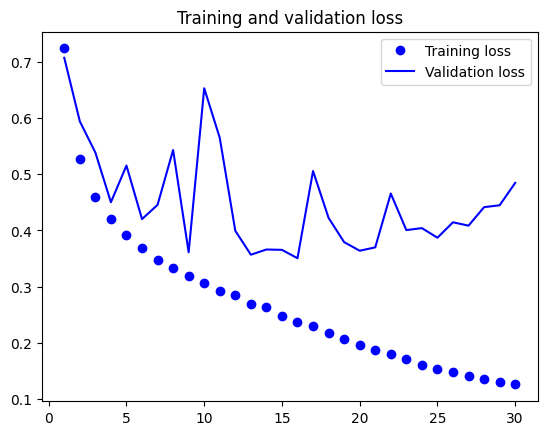

In [11]:
epochs = range(1, len(history4.history["loss"]) + 1)
loss = history4.history["loss"]
val_loss = history4.history["val_loss"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

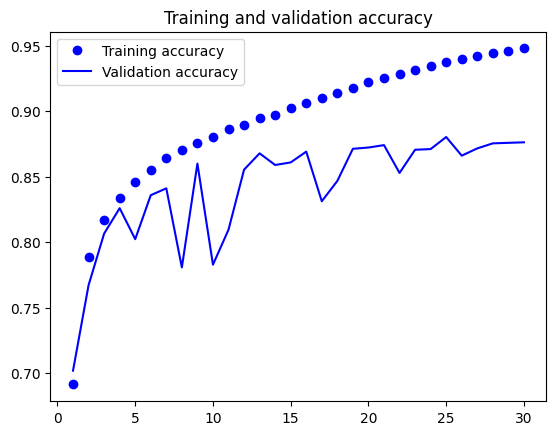

In [12]:
epochs = range(1, len(history4.history["accuracy"]) + 1)
loss = history4.history["accuracy"]
val_loss = history4.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

1/1 [==============================] - 0s 177ms/step


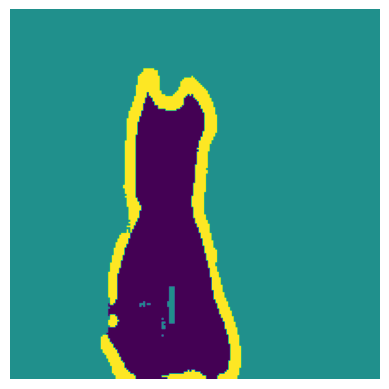

In [13]:
mask = model4.predict(np.expand_dims(test_image, 0))[0]

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    plt.imshow(mask)

display_mask(mask)

In [14]:
best_val_loss = min(history4.history['val_loss'])
print('Best validation loss:', best_val_loss)
best_val_accuracy = max(history4.history['val_accuracy'])
print('Best validation accuracy:', best_val_accuracy)

Best validation loss: 0.3506031334400177
Best validation accuracy: 0.8803216218948364


**Conclusion**

Batch normalization also improved the validation accuracy. The book says "no one really knows for sure why batch normalization helps" and that this is the case for "many things in deep learning". The sample test image segmentation does look very good without an imagined tail, though parts of the inside of the dog is classified as background.